# An Art Transformer


# Summary


# Deployment

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output

# Builds an art transformer adhering to the paper https://arxiv.org/pdf/1311.2901.pdf

## Utilities

In [2]:
def tensor_to_image(tensor):
    '''converts a tensor to an image'''
    tensor_shape = tf.shape(tensor)
    number_elem_shape = tf.shape(tensor_shape)
    if number_elem_shape > 3:
        assert tensor_shape[0] == 1
        tensor = tensor[0]
    return tf.keras.preprocessing.image.array_to_img(tensor) 


def load_img(path_to_img):
    '''loads an image as a tensor and scales it to 512 pixels'''
    max_dim = 512
    image = tf.io.read_file(path_to_img)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)

    shape = tf.shape(image)[:-1]
    shape = tf.cast(tf.shape(image)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    image = tf.image.resize(image, new_shape)
    image = image[tf.newaxis, :]
    image = tf.image.convert_image_dtype(image, tf.uint8)

    return image


def load_images(content_path, style_path):
    '''loads the content and path images as tensors'''
    content_image = load_img("{}".format(content_path))
    style_image = load_img("{}".format(style_path))

    return content_image, style_image


def imshow(image, title=None):
    '''displays an image with a corresponding title'''
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
    
    
def show_images_with_objects(images, titles=[]):
    '''displays a row of images with corresponding titles'''
    if len(images) != len(titles):
        return

    plt.figure(figsize=(20, 12))
    for idx, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), idx + 1)
        plt.xticks([])
        plt.yticks([])
        imshow(image, title)


def display_gif(gif_path):
    '''displays the generated images as an animated gif'''
    with open(gif_path,'rb') as f:
        display_fn(Image(data=f.read(), format='png'))


def create_gif(gif_path, images):
    '''creates animation of generated images'''
    mimsave(gif_path, images, fps=1)
  
    return gif_path


def clip_image_values(image, min_value=0.0, max_value=255.0):
    '''clips the image pixel values by the given min and max'''
    return tf.clip_by_value(image, clip_value_min=min_value, clip_value_max=max_value)


def preprocess_image(image):
    '''centers the pixel values of a given image to use with VGG-19'''
    image = tf.cast(image, dtype=tf.float32)
    image = tf.keras.applications.vgg19.preprocess_input(image)

    return image


In [3]:
K.clear_session()

tmp_vgg = tf.keras.applications.vgg19.VGG19()
tmp_vgg.summary()

# delete temporary variable
del tmp_vgg

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [4]:
#Choose style and content layers

style_layers = ['block1_conv1',
                'block1_conv2']

content_layers = ['block5_conv2', 
                  'block5_conv3']

output_layers = style_layers + content_layers

NUM_CONTENT_LAYERS = len(content_layers)
NUM_STYLE_LAYERS = len(style_layers)

In [5]:
def vgg_model(layer_names):
    """ Creates a vgg model 
  
    Args:
        layer_names: a list of layers as string
    
    Returns:
        Returns a (nontrainable) vgg model
  
    """

    # load the the pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')

    # freeze the weights of the model's layers (make them not trainable)
    vgg.trainable = False
  
    # create a list of layer objects that are specified by layer_names
    outputs = [vgg.get_layer(name).output for name in layer_names]

    # create the model that outputs content and style layers only
    model = tf.keras.Model(inputs=vgg.input, outputs=outputs)

    return model

In [6]:
K.clear_session()

vgg = vgg_model(output_layers)
vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [7]:
def get_style_loss(features, targets):
    """Computes the style loss between two tensors features and targets for the style"""
    
    style_loss = tf.reduce_mean(tf.square(features - targets))
    
    return style_loss

In [8]:
def get_content_loss(features, targets):
    """Computes the content loss between two tensors features and targets for the style"""
    
    style_loss = tf.reduce_sum(tf.square(features - targets))
    
    return style_loss

In [9]:
def gram_matrix(input_tensor):
    """ Calculates the gram matrix and divides by the number of locations
    Args:
        input_tensor: tensor of shape (batch, height, width, channels)
    
    Returns:
        scaled_gram: gram matrix divided by the number of locations
    """

    # calculate the gram matrix of the input tensor
    gram = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor) 

    # get the height and width of the input tensor
    input_shape = tf.shape(input_tensor) 
    height = input_shape[1] 
    width = input_shape[2] 

    # get the number of locations (height times width), and cast it as a tf.float32
    num_locations = tf.cast(height * width, tf.float32)

    # scale the gram matrix by dividing by the number of locations
    scaled_gram = gram / num_locations
    
    return scaled_gram

In [10]:
def get_style_image_features(image):
    
    image = tf.cast(image, dtype=tf.float32)
    preprocessed_style_image = tf.keras.applications.vgg19.preprocess_input(image)
    
    outputs = vgg(preprocessed_style_image)
    
    style_outputs = output_layers[:NUM_STYLE_LAYERS]
    
    gram_style_features = [gram_matrix(style_layer) for style_layer in style_outputs]
    
    return gram_style_features

In [11]:
def get_content_image_features(image):
    
    image = tf.cast(image, dtype=tf.float32)
    preprocessed_content_image = tf.keras.applications.vgg19.preprocess_input(image)
    
    outputs = vgg(preprocessed_content_image)
    
    content_outputs = output_layers[NUM_STYLE_LAYERS:]
    
    return content_outputs

In [12]:
def get_style_content_loss(style_targets, style_outputs, content_targets, 
                           content_outputs, style_weight, content_weight):
    
    style_loss = tf.add_n([ get_style_loss(style_output, style_target)
                           for style_output, style_target in zip(style_outputs, style_targets)])
    
    content_loss = tf.add_n([get_content_loss(content_output, content_target)
                           for content_output, content_target in zip(content_outputs, content_targets)])
    
    style_loss = style_loss * style_weight / (2*NUM_STYLE_LAYERS)
    
    content_loss = content_loss * content_weight / NUM_CONTENT_LAYERS
    
    total_loss = style_loss + content_loss
    
    return total_loss

In [13]:
def calculate_gradients(image, style_targets, content_targets, 
                        style_weight, content_weight, var_weight):
    
    style_features = get_style_image_features(image)
    
    content_features = get_content_image_features(image)
    
    loss = get_style_content_loss(style_targets, style_features, content_targets, 
                                  content_features, style_weight, content_weight)
    
    gradients = tape.gradient(loss, image)

In [14]:
def update_image_with_style(image, style_targets, content_targets, style_weight, 
                            var_weight, content_weight, optimizer):
    
    gradients = calculate_gradients(image, style_targets, content_targets, 
                                  style_weight, content_weight, var_weight)
    
    optimizer.apply_gradients([(gradients, image)])
    
    image.assign(clip_image_values(image, min_value=0.0, max_value=255.0))

In [15]:
def fit_style_transfer(style_image, content_image, style_weight=1e-2, content_weight=1e-4, 
                       var_weight=0, optimizer='adam', epochs=1, steps_per_epoch=1):

    images = []
    step = 0

    # get the style image features 
    style_targets = get_style_image_features(style_image)
    
    # get the content image features
    content_targets = get_content_image_features(content_image)

    # initialize the generated image for updates
    generated_image = tf.cast(content_image, dtype=tf.float32)
    generated_image = tf.Variable(generated_image) 
  
    # collect the image updates starting from the content image
    images.append(content_image)
  
    #   incrementally update the content image with the style features
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
    
      # Update the image with the style using the function that you defined
            update_image_with_style(generated_image, style_targets, content_targets, 
                                    style_weight, var_weight, content_weight, optimizer) 
    
            print(".", end='')

            if (m + 1) % 10 == 0:
                images.append(generated_image)
    
            # display the current stylized image
        clear_output(wait=True)
        display_image = tensor_to_image(generated_image)
        display_fn(display_image)

        # append to the image collection for visualization later
        images.append(generated_image)
        print("Train step: {}".format(step))
  
  # convert to uint8 (expected dtype for images with pixels in the range [0,255])
    generated_image = tf.cast(generated_image, dtype=tf.uint8)

    return generated_image, images

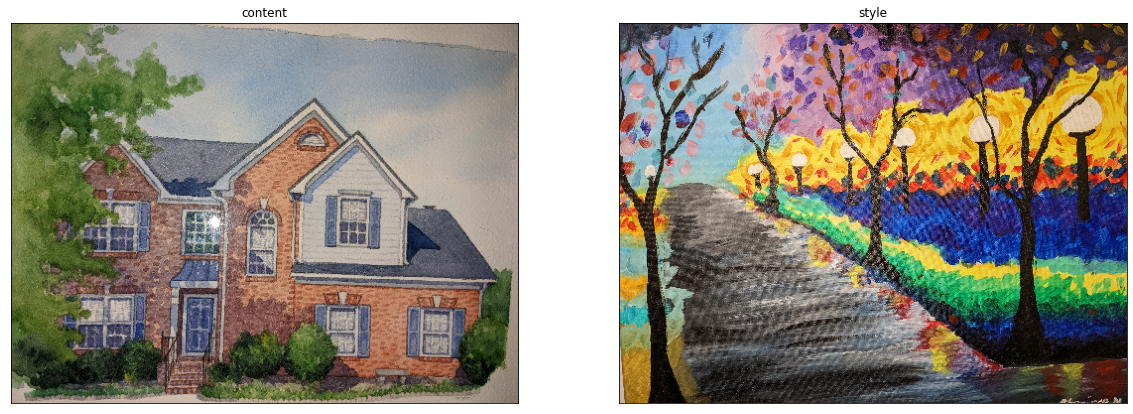

In [16]:
# define style and content weight

content_path = 'img/content.jpg'
style_path= 'img/style.jpg'
content_image, style_image = load_images(content_path, style_path)
show_images_with_objects([content_image, style_image], titles=['content','style'])

In [17]:
style_weight =  2e-2
content_weight = 1e-2 

# define optimizer. learning rate decreases per epoch.
adam = tf.optimizers.Adam(
    tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=20.0, decay_steps=100, decay_rate=0.50
    )
)

# start the neural style transfer
stylized_image, display_images = fit_style_transfer(style_image=style_image, content_image=content_image, 
                                                    style_weight=style_weight, content_weight=content_weight,
                                                    var_weight=0, optimizer=adam, epochs=10, steps_per_epoch=100)

AttributeError: 'str' object has no attribute 'shape'